# Limiarização de imagens

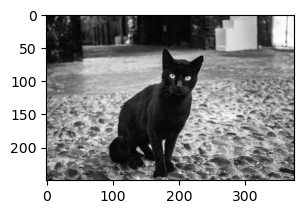

In [1]:
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread('cat.tiff')
plt.imshow(img, 'gray')

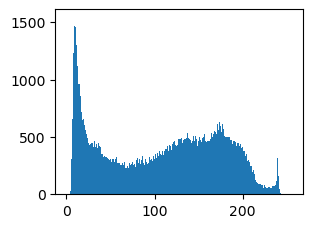

In [2]:
_ = plt.hist(img.ravel(), range(257))

## 1. Limiarização simples

Vamos tentar segmentar o gato da imagem acima. Primeiro, utilizaremos um método simples de médias sucessivas.

In [3]:
def simple_threshold(img):
    '''Estima limiar através do cálculo das médias de intensidade dos pixels
       background e foreground'''
    
    num_rows, num_cols = img.shape
    threshold = np.mean(img)
    has_finished = False
    while not has_finished:
        print(threshold)
        num_back = 0
        sum_back = 0
        num_fore = 0
        sum_fore = 0        
        for row in range(num_rows):
            for col in range(num_cols):        
                if img[row, col]<threshold:
                    num_back += 1
                    sum_back += img[row, col]
                else:
                    num_fore += 1
                    sum_fore += img[row, col]
                    
        mean_back = sum_back/num_back   # Intensidade média de pixels background
        mean_fore = sum_fore/num_fore   # Intensidade média de pixels foreground
        # Os dois laços for acima podem ser substituídos por
        #img_bin = img>threshold
        #mean_back = np.mean(img[img_bin==False])
        #mean_fore = np.mean(img[img_bin==True])
        
        prev_threshold = threshold
        threshold = (mean_back+mean_fore)/2
        if np.abs(threshold-prev_threshold)<1e-6:
            has_finished = True
                        
    return threshold

107.110016
103.03784741892899
101.23384919590512
100.36097551526422
99.90981434502736
99.53850551142071
Threshold escolhido: 99.53850551142071


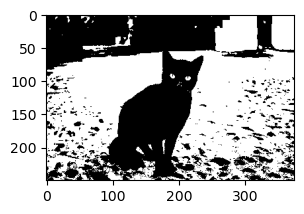

In [4]:
thresh = simple_threshold(img)
print('Threshold escolhido: {}'.format(thresh))
binary_image = img>=thresh
plt.imshow(binary_image, 'gray')

## 2. Limiarização de Otsu

A limiarização de Otsu consiste em encontrar o limiar tal que o valor de

\begin{equation}
\sigma_I^2=P_B(m_B-m_G)^2+P_F(m_F-m_G)^2
\end{equation}

seja máximo.

In [ ]:
def threshold_otsu_naive(img):
    '''Calcula o limiar de Otsu de forma ineficiente, mas simples de ser entendida'''
    
    num_rows, num_cols = img.shape
    num_pixels = img.shape[0]*img.shape[1]   # Número de pixels na imagem
    sum_img = np.sum(img)                    # Soma das intensidades
    m_G = sum_img/num_pixels                 # Intensidade média
    
    sigma_vals = []
    max_sigma_I = -1
    for threshold in range(0, 256):
        num_back = 0
        sum_back = 0

        for row in range(num_rows):
            for col in range(num_cols):
                if img[row, col]<=threshold:
                    num_back += 1
                    sum_back += img[row, col]
        num_fore = num_pixels - num_back
        sum_fore = sum_img - sum_back
        
        if num_back==0 or num_fore==0:
            continue
        
        P_back = num_back/num_pixels  # Fração de pixels background
        P_fore = num_fore/num_pixels  # Fração de pixels foreground
        m_back = sum_back/num_back    # Média de intensidade de pixels background
        m_fore = sum_fore/num_fore    # Média de intensidade de pixels foreground
        
        sigma_I = P_back*(m_back-m_G)**2 + P_fore*(m_fore-m_G)**2
        sigma_vals.append(sigma_I)
        
        if sigma_I>max_sigma_I:
            max_sigma_I = sigma_I
            best_threshold = threshold
    
    return best_threshold

thresh = threshold_otsu_naive(img)
print('Threshold escolhido: {}'.format(thresh))

In [ ]:
def threshold_otsu(img):
    '''Calcula o limiar de Otsu utilizando o histograma da imagem'''
    
    bins = range(0, 257)
    hist, _ = np.histogram(img, bins)
    
    num_pixels = img.shape[0]*img.shape[1] 
    sum_img = np.sum(img)
    m_G = sum_img/num_pixels
    max_sigma_I = -1
    
    sigma_vals = np.zeros(256)
    sum_back = 0
    num_back = 0
    for threshold in range(0, 256):
        num_back = num_back + hist[threshold]  # Número de pixels com valor menor que threshold
        sum_back = sum_back + threshold*hist[threshold]  # Soma dos valores de pixel background

        num_fore = num_pixels - num_back
        sum_fore = sum_img - sum_back
        
        if num_back == 0 or num_fore == 0:
            continue
        
        P_back = num_back/num_pixels
        P_fore = num_fore/num_pixels
        m_back = sum_back/num_back   
        m_fore = sum_fore/num_fore    
        
        sigma_I = P_back*(m_back-m_G)**2 + P_fore*(m_fore-m_G)**2
        sigma_vals[threshold] = sigma_I
        
        if sigma_I > max_sigma_I:
            max_sigma_I = sigma_I
            best_threshold = threshold
    return best_threshold, sigma_vals

thresh, sigma_vals = threshold_otsu(img)
print('Threshold escolhido: {}'.format(thresh))

In [ ]:
plt.plot(range(0, 256), sigma_vals)